# 10. DBscane: Clustering by Density and Finding Outliers

**Course Section:** 10
**Topics:** Unsupervised Learning, Clustering, Density-Based Clustering, Outlier Detection.
**Dataset:** Synthetic datasets (`make_moons`, `make_blobs`) for clear visualization.

---

## 10.1. The Problem with K-Means 

Let's quickly remember K-Means. It tries to find a specified number of spherical cluster centers. But what happens when the data isn't spherical?

Let's generate two interleaving half-moon shapes. Intuitively, we see two clear clusters.


C:\Users\Surface Laptop 3\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


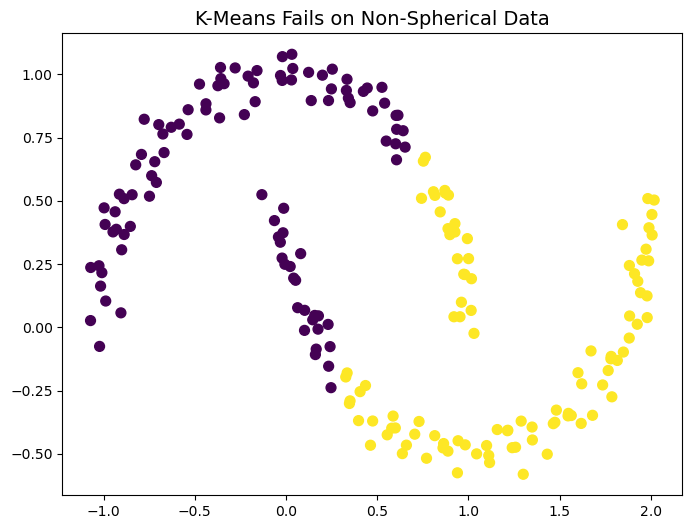

In [1]:
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Generate non-spherical data
X_moons, y_moons = make_moons(n_samples=200, noise=0.05, random_state=0)

# Apply K-Means
kmeans = KMeans(n_clusters=2, random_state=0)
labels_kmeans = kmeans.fit_predict(X_moons)

# Visualize K-Means result
plt.figure(figsize=(8, 6))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=labels_kmeans, s=50, cmap='viridis')
plt.title("K-Means Fails on Non-Spherical Data", fontsize=14)
plt.show()

## 10.2. The DBSCAN Intuition: A Party Analogy 
Imagine you are at a party. How do you identify different groups of friends?
*   You look for **crowded areas**.
*   A person is part of a group if they are **close to several other people** in that group.
*   Someone standing alone in a corner is an **outlier** (not part of any group).

DBSCAN works exactly the same way. It formalizes this with two key parameters:
1.  **`eps` (ε):** A distance radius. "How close does someone have to be to be considered a neighbor?"
2.  **`min_samples`:** A minimum number of points. "How many neighbors must a point have within its `eps` radius to be considered a 'core' part of a crowd?"

Based on these, DBSCAN classifies every point into one of three types:
*   **Core Point:** A point that has at least `min_samples` neighbors (including itself) within its `eps` radius. These are the hearts of the clusters.
*   **Border Point:** A point that is a neighbor of a core point but doesn't have enough neighbors itself. It's on the edge of a cluster.
*   **Noise Point:** A point that is neither a core nor a border point. These are the outliers.

A cluster is formed by starting with a core point and recursively grabbing all reachable core and border points.

---

## 10.3. Implementation: DBSCAN to the Rescue (Code)

Let's apply DBSCAN to our `moons` dataset.

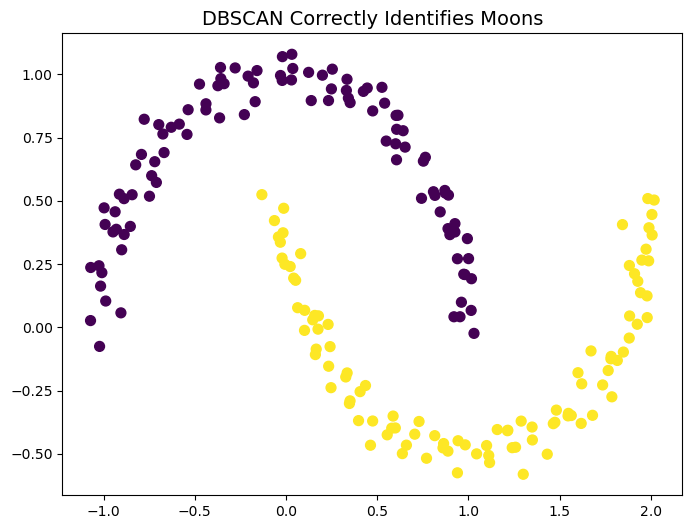

Unique cluster labels found: [0 1]


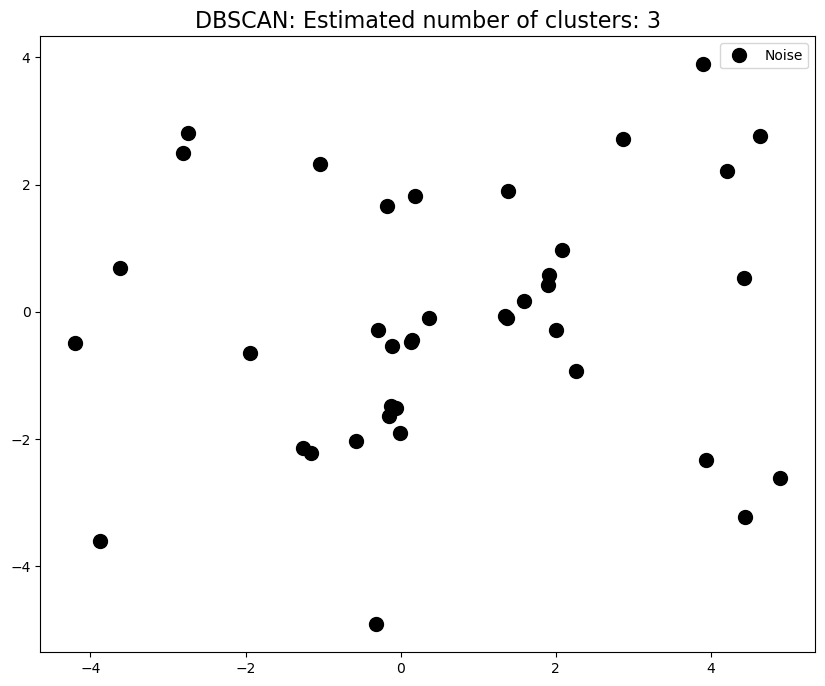

'\nThe plot beautifully shows the three main clusters, and the scattered points are correctly identified as **Noise** (labeled -1 and colored black).\n'

In [6]:
### Step 1: Import and Apply DBSCAN

from sklearn.cluster import DBSCAN

# Initialize and run DBSCAN
# The values for eps and min_samples often require some tuning.
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_moons)

# Visualize DBSCAN result
plt.figure(figsize=(8, 6))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=labels_dbscan, s=50, cmap='viridis')
plt.title("DBSCAN Correctly Identifies Moons", fontsize=14)
plt.show()

# Check the unique labels found
print(f"Unique cluster labels found: {np.unique(labels_dbscan)}")

### Step 2: Identifying Noise Points

# Let's use a different dataset to see how DBSCAN handles outliers.

from sklearn.datasets import make_blobs

# Generate data with some outliers
centers = [[1, 1], [-1, -1], [1, -1]]
X_blobs, _ = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
# Manually add some noise
noise = np.random.rand(20, 2) * 10 - 5
X_with_noise = np.vstack([X_blobs, noise])

# Apply DBSCAN
dbscan_noise = DBSCAN(eps=0.3, min_samples=10)
labels_noise = dbscan_noise.fit_predict(X_with_noise)

# Plotting the results
unique_labels = set(labels_noise)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(10, 8))
for k, col in zip(unique_labels, colors):
    if k == -1:
# Black used for noise.
        col = [0, 0, 0, 1]

class_member_mask = (labels_noise == k)
xy = X_with_noise[class_member_mask]

label_text = 'Noise' if k == -1 else f'Cluster {k}'
plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
markeredgecolor='k', markersize=10, label=label_text)

plt.title(f'DBSCAN: Estimated number of clusters: {len(unique_labels)-1}', fontsize=16)
plt.legend()
plt.show()
'''
The plot beautifully shows the three main clusters, and the scattered points are correctly identified as **Noise** (labeled -1 and colored black).
'''

## 10.4. How to Choose `eps`?

The biggest challenge with DBSCAN is choosing a good `eps`. A common heuristic is the **K-distance graph**:
1.  Set `k = min_samples`.
2.  For every point in your dataset, find the distance to its `k`-th nearest neighbor.
3.  Plot these distances in sorted order.
4.  The "elbow" of this plot is a good candidate for `eps`. It represents the point where the distances start increasing sharply, separating the dense areas from the sparse (noise) areas.



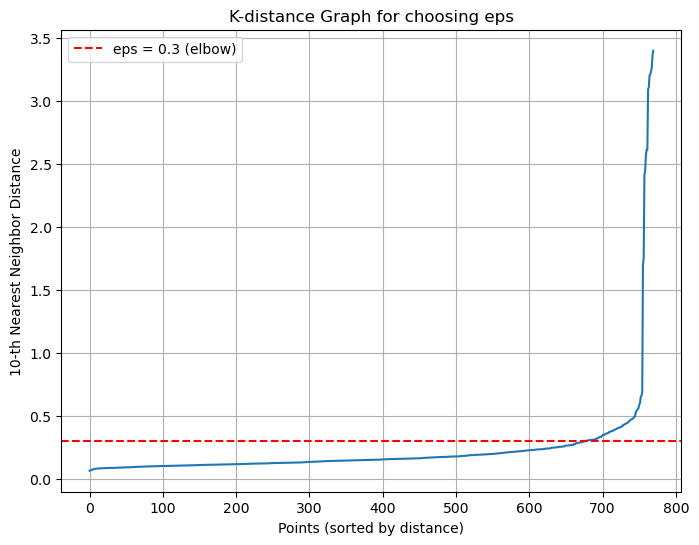

In [11]:
from sklearn.neighbors import NearestNeighbors

# Let's use min_samples = 10 as before
k = 10
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_with_noise)
distances, indices = neighbors_fit.kneighbors(X_with_noise)

# Sort distances to the k-th neighbor
k_distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_distances)
plt.xlabel("Points (sorted by distance)")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.title("K-distance Graph for choosing eps")
plt.grid(True)
# Add a horizontal line at the "elbow"
plt.axhline(y=0.3, color='r', linestyle='--', label='eps = 0.3 (elbow)')
plt.legend()
plt.show()
# The plot shows a clear "elbow" around a distance of 0.3, validating our choice for `eps` in the previous example.
